You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# What's a chartist?

Recently I heard the word "chartist" for the first time in my life (that I recall).
And then later the same day, I heard it again.
So that raises two questions:

* What are the chances of going 57 years without hearing a word, and then hearing it twice in one day?

* Also, what's a chartist?

To answer the second question first, it's someone who supported chartism, which was "a working-class movement for political reform in the United Kingdom that erupted from 1838 to 1857", quoth [Wikipedia](https://en.wikipedia.org/wiki/Chartism).  The name comes from the People's Charter of 1838, which called for voting rights for unpropertied men.

To answer the first question, we'll do some Bayesian statistics.
My solution is based on a model that's not very realistic, so we should not take the result too seriously.
But it demonstrates some interesting methods, I think -- and as you'll see, there is a connection to Zipf's law, [which I wrote about last week](https://www.allendowney.com/blog/2024/11/10/zipfs-law/).

In [251]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [252]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [253]:
# download thinkdsp.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py")

<IPython.core.display.Javascript object>

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

<IPython.core.display.Javascript object>

## Word Frequencies

If you don't hear a word for more than 50 years, that suggests it is not a common word.
We can use Bayes's theorem to quantify this intuition.
First we'll compute the posterior distribution of the word's frequency, then the posterior predictive distribution of hearing it again within a day.

Because we have only one piece of data -- the time until first appearance -- we'll need a good prior distribution.
Which means we'll need a large, good quality sample of English text.
For that, I'll use a free sample of the COCA dataset from [CorpusData.org](https://www.corpusdata.org/formats.asp). The following cells download and read the data.

In [255]:
download("https://www.corpusdata.org/coca/samples/coca-samples-text.zip")

<IPython.core.display.Javascript object>

In [256]:
import zipfile


def generate_lines(zip_path="coca-samples-text.zip"):
    with zipfile.ZipFile(zip_path, "r") as zip_file:
        file_list = zip_file.namelist()
        for file_name in file_list:
            with zip_file.open(file_name) as file:
                lines = file.readlines()
                for line in lines:
                    yield (line.decode("utf-8"))

<IPython.core.display.Javascript object>

We'll use a `Counter` to count the number of times each word appears.

In [257]:
import re
from collections import Counter

counter = Counter()

pattern = r"[ /\n]+|--"

for line in generate_lines():
    words = re.split(pattern, line)[1:]
    counter.update(word.lower() for word in words if word)

<IPython.core.display.Javascript object>

The dataset includes more than 190,000 unique strings, but not all of them are what we would consider words.

In [258]:
num_words = counter.total()
len(counter), num_words

(188086, 11503819)

<IPython.core.display.Javascript object>

To narrow it down, I'll remove anything that starts or ends with a non-alphabetical character -- so hyphens and apostrophes are allowed in the middle of a word.

In [259]:
for s in list(counter.keys()):
    if not s[0].isalpha() or not s[-1].isalpha():
        del counter[s]

<IPython.core.display.Javascript object>

This filter reduces the number of unique words to about 154,000.

In [260]:
num_words = counter.total()
len(counter), num_words

(151414, 8889694)

<IPython.core.display.Javascript object>

The most common words are what you would expect, with the exception of "n't", which is there because the COCA corpus treats it as a separate word.

In [261]:
counter.most_common(20)

[('the', 461991),
 ('to', 237929),
 ('and', 231459),
 ('of', 217363),
 ('a', 203302),
 ('in', 153323),
 ('i', 137931),
 ('that', 123818),
 ('you', 109635),
 ('it', 103712),
 ('is', 93996),
 ('for', 78755),
 ('on', 64869),
 ('was', 64388),
 ('with', 59724),
 ('he', 57684),
 ('this', 51879),
 ('as', 51202),
 ("n't", 49291),
 ('we', 47694)]

<IPython.core.display.Javascript object>

There are about 72,000 words that only appear once in the corpus, technically known as [hapax legomena](https://en.wikipedia.org/wiki/Hapax_legomenon).

In [322]:
singletons = [word for (word, freq) in counter.items() if freq == 1]
len(singletons), len(singletons) / counter.total() * 100

(72159, 0.811715228893143)

<IPython.core.display.Javascript object>

Here's a random selection of them. Many are proper names, typos, or other non-words, but some are legitimate but rare words.

In [263]:
np.random.choice(singletons, 100)

array(['perfact', 'feidhauses', 'laven', 'osmany', 'nnessee', 'baccardi',
       'eventuate', 'pagando', 'capsulate', 'r-miami', 'soyrizo',
       'narcotic-analgesic', 'phanar', 'midwater', 'chalker', 'fittv',
       'diplomatie', 'queso-broccoli', 'session-and', 'caricaturistes',
       'reverand', 'mesdames', 'flender', 'synchronistic', 'boom-era',
       'litvak', 'skowhegan', 'wailers', 'ambroeus', 'treximet', 'jonell',
       'soundwriters', 'pre-oiled', 'brimless', 'meta-billboard',
       'leather-strapped', 'ludvigsen', 'half-indian', 'bandmembers',
       'pinky-ness', 'pro-marriage-equality', 'bbed', 'sgarlatti',
       'flash-free', 'satelitte', 'goheen', 'med-school', 'lune',
       'remuddled', 'work-rule', 'seawolf', 'instuments', 'gaudiest',
       "they'lltell", 'bahrainis', 'deacetylation', 'birth-and-being',
       'captionrodeo', 'cropper', 'dry-mounting', 'marijuana-related',
       'sidelining', 'forexpros', 'aisa', 'naxos', 'g6pd', 'extirpation',
       'colonisi

<IPython.core.display.Javascript object>

Now let's see what the distribution of word frequencies looks like.

## Zipf's Law

One way to visualize the distribution is a Zipf plot, which shows the ranks on the x-axis and the frequencies on the y-axis.

In [331]:
freqs = sorted(counter.values(), reverse=True)

<IPython.core.display.Javascript object>

In [332]:
n = len(freqs)
ranks = range(1, n + 1)

<IPython.core.display.Javascript object>

Here's what it looks like on a log-log scale.

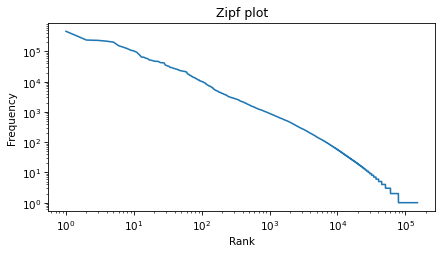

<IPython.core.display.Javascript object>

In [333]:
plt.plot(ranks, freqs)

decorate(
    title="Zipf plot", xlabel="Rank", ylabel="Frequency", xscale="log", yscale="log"
)

Zipf's law suggest that the result should be a straight line with slope close to -1.
It's not exactly a straight line, but it's close, and the slope is about -1.1.

In [334]:
rise = np.log10(freqs[-1]) - np.log10(freqs[0])
rise

-5.664633515191604

<IPython.core.display.Javascript object>

In [335]:
run = np.log10(ranks[-1]) - np.log10(ranks[0])
run

5.180166032638616

<IPython.core.display.Javascript object>

In [336]:
rise / run

-1.0935235433575892

<IPython.core.display.Javascript object>

The Zipf plot is a well-known visual representation of the distribution of frequencies, but for the current problem, we'll switch to a different representation.

## Tail Distribution

Given the number of times each word appear in the corpus, we can compute the rates, which is the number of times we expect each word to appear in a sample of a given size, and the inverse rates, which are the number of words we need to see before we expect a given word to appear.

We will find it most convenient to work with the distribution of inverse rates on a log scale.
Here are the inverse rates:

In [267]:
def describe(seq):
    return pd.Series(seq).describe()

<IPython.core.display.Javascript object>

In [268]:
n = counter.total()
rates = np.array(freqs) / n
inverse_rate = 1 / rates
describe(inverse_rates)

count    151414.000000
mean          6.604409
std         221.228503
min           0.112490
25%           0.112490
50%           0.224980
75%           0.674939
max       51969.280382
dtype: float64

<IPython.core.display.Javascript object>

And here are their magnitudes, expressed as logarithms base 10.

In [278]:
mags = np.log10(inverse_rates)
describe(mags)

count    151414.000000
mean          6.341648
std           0.673543
min           1.285082
25%           6.062383
50%           6.456414
75%           6.758455
max           9.275781
dtype: float64

<IPython.core.display.Javascript object>

From the `empiricaldist` library, we'll use the `Surv` object, which represents survival functions, but we'll use a variation of the survival function which is the probability that a randomly-chosen value is greater than or equal to a given quantity.
The following function computes this version of a survival function, which is called a tail probability.

In [279]:
from empiricaldist import Surv


def make_surv(seq):
    """Make a non-standard survival function, P(X>=x)"""
    pmf = Pmf.from_seq(seq)
    surv = pmf.make_surv() + pmf

    # correct for numerical error
    surv.iloc[0] = 1
    return Surv(surv)

<IPython.core.display.Javascript object>

Here's how we make the survival function.

In [318]:
surv = make_surv(mags)

<IPython.core.display.Javascript object>

And here's what it looks like.

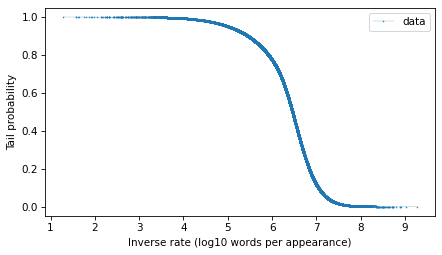

<IPython.core.display.Javascript object>

In [319]:
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (log10 words per appearance)", ylabel="Tail probability")

The tail distribution has the sigmoid shape that is characteristic of normal distributions and $t$ distributions, although it is notably asymmetric.

And here's what the tail probabilities look like on a log-y scale.

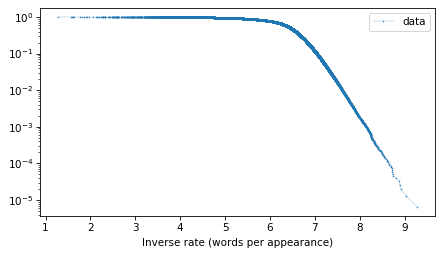

<IPython.core.display.Javascript object>

In [320]:
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (words per appearance)", yscale="log")

If this distribution were normal, we would expect this curve to drop off with increasing slope.
But for the words with the lowest frequencies -- that is, the highest inverse rates -- it is almost a straight line.
And that suggests that a $t$ distribution might be a good model for this data.

## Fitting a Model

To estimate the frequency of rare words, we will need to model the tail behavior of this distribution and extrapolate it beyond the data.
So let's fit a $t$ distribution and see how it looks.
I'll use code from Chapter 8 of *Probably Overthinking It*, which is all about these long-tailed distributions.

The following function makes a `Surv` object that represents a $t$ distribution with the given parameters.

In [291]:
from scipy.stats import t as t_dist


def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

<IPython.core.display.Javascript object>

If we are given the `df` parameter, we can use the following function to find the values of `mu` and `sigma` that best fit the data, focusing on the central part of the distribution.

In [292]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)
    ps = np.linspace(0.01, 0.8, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    pmf = surv.make_pmf()
    pmf.normalize()
    params = pmf.mean(), pmf.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x

<IPython.core.display.Javascript object>

But since we are not given `df`, we can use the following function to search for the value that best fits the tail of the distribution.

In [293]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e3)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.2, 2000)

    if ps is None:
        t = surv.ps[0], surv.ps[-5]
        low, high = np.log10(t)
        ps = np.logspace(low, high, 30, endpoint=False)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        print(df)
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

<IPython.core.display.Javascript object>

In [307]:
df = minimize_df(25, surv)
df

25.0
382.58404523885497
618.4159547611448
236.8319095222899
146.75213571656514
91.07977380572478
56.67236191084039
35.407411894884405
22.26495001595599
14.142461878928419
26.396431469641538
22.378315526830374
23.37711806078531
24.53039316028008
23.209065736046366
23.229227282976307
23.225700629153852
23.225367269503405
23.226033988804296
21.451401258307705
382.58404523885497
618.4159547611448
236.83190952228992
146.75213571656516
91.07977380572477
56.67236191084038
35.407411894884405
22.26495001595599
14.142461878928419
26.396431469641538
22.378315526830374
23.37711806078531
24.53039316028008
23.209065736046366
23.229227282976307
23.225700629153852
23.22536729582052
23.22503396248224


array([23.2253673])

<IPython.core.display.Javascript object>

In [308]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([23.2253673]), 6.431987258334933, 0.4916380552135185)

<IPython.core.display.Javascript object>

Here's the `t` distribution that best fits the data.

In [389]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.1 * high, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)

<IPython.core.display.Javascript object>

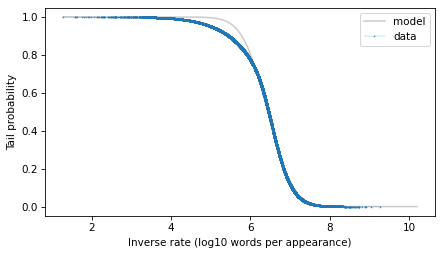

<IPython.core.display.Javascript object>

In [390]:
surv_model.plot(color="gray", alpha=0.4, label="model")
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(xlabel="Inverse rate (log10 words per appearance)", ylabel="Tail probability")

With the y-axis on a linear scale, we can see that the model fits the data reasonably well, except for a range in the middle of the distribution -- the words that are not common or rare.

And here's what the model looks like on a log-y scale.

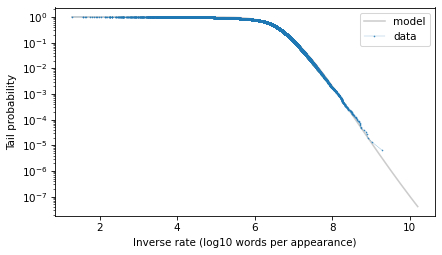

<IPython.core.display.Javascript object>

In [391]:
surv_model.plot(color="gray", alpha=0.4, label="model")
surv.plot(marker=".", ms=1, lw=0.2, label="data")
decorate(
    xlabel="Inverse rate (log10 words per appearance)",
    ylabel="Tail probability",
    yscale="log",
)

## Make a Prior

<Axes: >

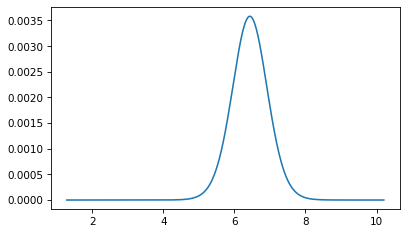

<IPython.core.display.Javascript object>

In [394]:
prior = surv_model.make_pmf()
prior.plot()

## Update It

In [384]:
ps = 1 / np.power(10, prior.qs)
describe(ps)

count    2.000000e+03
mean     2.753817e-03
std      8.012930e-03
min      3.162278e-10
25%      3.578765e-08
50%      4.050083e-06
75%      4.583447e-04
max      5.187022e-02
dtype: float64

<IPython.core.display.Javascript object>

In [385]:
words_per_day = 10_000
days = 50 * 365
days * words_per_day

182500000

<IPython.core.display.Javascript object>

In [386]:
from scipy.stats import nbinom

k = days * words_per_day
n = 1

likelihood = nbinom.pmf(k, n, ps)
describe(likelihood)

count    2.000000e+03
mean     2.733730e-10
std      5.653541e-10
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.216238e-11
max      2.015761e-09
dtype: float64

<IPython.core.display.Javascript object>

In [387]:
posterior = prior * likelihood
posterior.normalize()

1.3558684208624722e-11

<IPython.core.display.Javascript object>

<Axes: >

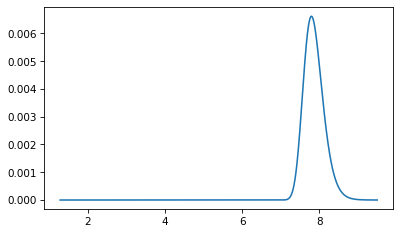

<IPython.core.display.Javascript object>

In [388]:
posterior.plot()

## Make a Prediction

In [357]:
n_pred = words_per_day
ps_pred = binom.sf(0, n_pred, ps)

<IPython.core.display.Javascript object>

In [358]:
p = np.sum(posterior * ps_pred)
p, 1 / p

(0.00016066773432600893, 6224.0250302584855)

<IPython.core.display.Javascript object>

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)